<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Signal Processing</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Fourier Transformation</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Stefanie Donner ([@stefdonner](https://github.com/stefdonner))
* Celine Hadziioannou ([@hadzii](https://github.com/hadzii))
* Ceri Nunn ([@cerinunn](https://github.com/cerinunn))

<br>
Some code used in this tutorial is taken from [stackoverflow.com](http://stackoverflow.com/questions/4258106/how-to-calculate-a-fourier-series-in-numpy/27720302#27720302). We thank [Giulio Ghirardo](https://www.researchgate.net/profile/Giulio_Ghirardo) for his kind permission to use his code here.


---

<h1>Tutorial on Fourier transformation in 1D </h1>
<br>

In [1]:
from __future__ import print_function

# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
from scipy import signal
from obspy.signal.invsim import cosine_taper 
from matplotlib import rcParams
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 3

## The Fourier transformation

In the world of seismology, we use the *Fourier transformation* to transform a signal from the time domain into the frequency domain. That means, we split up the signal and separate the content of each frequency from each other. Doing so, we can analyse our signal according to energy content per frequency. We can extract information on how much amplitude each frequency contributes to the final signal. In other words: we get a receipt of the ingredients we need to blend our measured signal. 

The *Fourier transformation* is based on the *Fourier series*. With the *Fourier series* we can approximate an (unknown) function $f(x)$ by another function $g_n(x)$ which consists of a sum over $N$ basis functions weighted by some coefficients. The basis functions need to be orthogonal. $sin$ and $cos$ functions seem to be a pretty good choice because any signal can be filtered into several sinusoidal paths. In the period range of $[-T/2 ; T/2]$ the *Fourier series* is defined as:

$$
f(t) \approx g_n(t) = \frac{1}{2} a_0 + \sum_{k=1}^N \left[ a_k \cos \left(\frac{2\pi k t}{T} \right) + b_k \sin\left(\frac{2\pi k t}{T}\right)\right]
$$

$$ 
a_k = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \cos\left(\frac{2\pi k t}{T}\right)dt
$$

$$
b_k = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \sin\left(\frac{2\pi k t}{T}\right)dt
$$

At this stage, we consider continuous, periodic and infinite functions. The more basis functions are used to approximate the unknown function, the better is the approximation, i.e. the more similar the unknown function is to its approximation. 

For a non-periodic function the interval of periodicity tends to infinity. That means, the steps between neighbouring frequencies become smaller and smaller and thus the infinite sum of the *Fourier series* turns into an integral and we end up with the integral form of the *Fourier transformation*:

$$
F(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt \leftrightarrow f(t) =  \int_{-\infty}^{\infty} F(\omega)e^{i\omega t}dt
$$

Attention: sign and factor conventions can be different in the literature!

In seismology, we do not have continuous but discrete time signals. Therefore, we work with the discrete form of the *Fourier transformation*:

$$
F_k = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2\pi i k j /N} \leftrightarrow f_k = \sum_{j=0}^{N-1} F_j e^{2\pi i k j /N}
$$

Some intuitive gif animations on what the *Fourier transform* is doing, can be found [here](https://en.wikipedia.org/wiki/File:Fourier_series_and_transform.gif), [here](https://en.wikipedia.org/wiki/File:Fourier_series_square_wave_circles_animation.gif), and [here](https://en.wikipedia.org/wiki/File:Fourier_series_sawtooth_wave_circles_animation.gif).
Further and more detailed explanations on *Fourier series* and *Fourier transformations* can be found [here](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/) and [here](www.fourier-series.com).

---

### The Fourier series and its coefficients 

In the following two code cells, we first define a function which calculates the coefficients of the Fourier series for a given function. The function in the next cell does it the other way round: it is creating a function based on given coefficients and weighting factors.

In [2]:
# Cell 1: code by Giulio Ghirardo  
def fourier_series_coeff(f, T, N):
    """Calculates the first 2*N+1 Fourier series coeff. of a periodic function.

    Given a periodic, function f(t) with period T, this function returns the
    coefficients a0, {a1,a2,...},{b1,b2,...} such that:

    f(t) ~= a0/2+ sum_{k=1}^{N} ( a_k*cos(2*pi*k*t/T) + b_k*sin(2*pi*k*t/T) )
    
    Parameters
    ----------
    f : the periodic function, a callable like f(t)
    T : the period of the function f, so that f(0)==f(T)
    N_max : the function will return the first N_max + 1 Fourier coeff.

    Returns
    -------
    a0 : float
    a,b : numpy float arrays describing respectively the cosine and sine coeff.
    """
    # From Nyquist theorem we must use a sampling 
    # freq. larger than the maximum frequency you want to catch in the signal. 
    f_sample = 2 * N
    
    # We also need to use an integer sampling frequency, or the
    # points will not be equispaced between 0 and 1. We then add +2 to f_sample.
    t, dt = np.linspace(0, T, f_sample + 2, endpoint=False, retstep=True)
    y = np.fft.rfft(f) / t.size
    y *= 2
    return y[0].real, y[1:-1].real[0:N], -y[1:-1].imag[0:N]

In [3]:
# Cell 2: code by Giulio Ghirardo  
def series_real_coeff(a0, a, b, t, T):
    """calculates the Fourier series with period T at times t,
       from the real coeff. a0,a,b"""
    tmp = np.ones_like(t) * a0 / 2.
    for k, (ak, bk) in enumerate(zip(a, b)):
        tmp += ak * np.cos(2 * np.pi * (k + 1) * t / T) + bk * np.sin(
            2 * np.pi * (k + 1) * t / T)
    return tmp

---  
Now, we can create an arbitrary function, which we use to experiment with in the following example.   
1) When you re-run cell 3 several times, do you always see the same function? Why? What does it tell you about the Fourier series?  

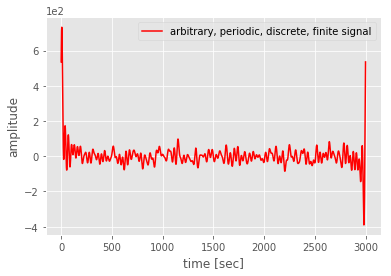

In [4]:
# Cell 3: create periodic, discrete, finite signal

# number of samples (intial value: 3000)
samp = 3000
# sample rate (initial value: 1)
dt = 1
# period
T = 1.0 / dt
length = samp * dt
# number of coefficients (initial value: 100)
N = 100
# weighting factors for coefficients (selected randomly)
a0 = np.random.rand(1)
a = np.random.randint(1, high=11, size=N)
b = np.random.randint(1, high=11, size=N)

t = np.linspace(0, length, samp)             # time axis
sig = series_real_coeff(a0, a, b, t, T)

# plotting
plt.plot(t, sig, 'r', label='arbitrary, periodic, discrete, finite signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

---  
Now, we can play with the signal and see what happens when we try to reconstruct it with a limited number of coefficients.  
2) Run the cells 4 and 5. What do you observe?  
3) Increase the number of coefficients $n$ step by step and re-run cells 4 and 5. What do you observe now? Can you explain?   
4) In cell 5 uncomment the lines to make a plot which is not normalized (and comment the other two) and re-run the cell. What do you see now and can you explain it?

In [5]:
# Cell 4: determine the first 'n' coefficients of the function using the code function of cell 1
T = 1        # period
n = 5        # number of coeffs to reconstruct
a0, a, b = fourier_series_coeff(sig, T, n)
a_ = a.astype(int)
b_ = b.astype(int)
print('coefficient a0 = ', int(a0))
print('array coefficients ak =', a_)
print('array coefficients bk =', b_)

coefficient a0 =  254
array coefficients ak = [1589 2089 1840  843  593]
array coefficients bk = [ 251  253 1005 1509  763]


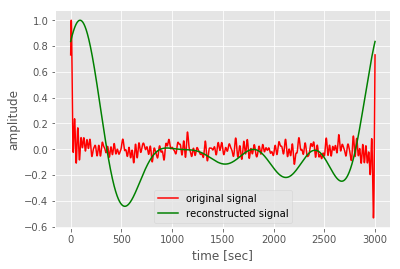

In [6]:
# Cell 5: reconstruct the function using the code in cell 2
g = series_real_coeff(a0, a, b, t, dt)

# plotting
#plt.plot(t, sig, 'r', label='original signal')          # NOT normalized 
#plt.plot(t, g, 'g', label='reconstructed signal')
plt.plot(t, sig/max(sig), 'r', label='original signal')  # normalized 
plt.plot(t, g/max(g), 'g', label='reconstructed signal')

plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

---

### Fourier series, convergence and Gibb's phenomenon

As seen above the convergence of the *Fourier series* can be tricky due to the fact that we work with signals of finite length. To analyse this effect in a bit more detail, we define a square wave in cell 6 and try to reconstruct it in cell 7.  
5) First, we use only 5 coefficients to reconstruct the wave. Describe what you see.  
6) Increase the number of coefficients $n$ in cell 7 step by step and re-run the cell.  What do you see now? Can you explain it?

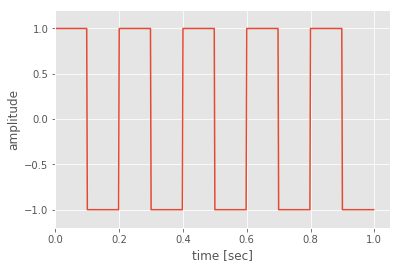

In [7]:
# Cell 6: define a square wave of 5 Hz
freq = 5.
npts = 500
dt_ = 0.002
length = npts * dt_
t_ = np.linspace(0, length, npts, endpoint=False)
square = signal.square(2 * np.pi * freq * t_)

plt.plot(t_, square)
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.xlim(0, 1.05)
plt.ylim(-1.2, 1.2)
plt.show()

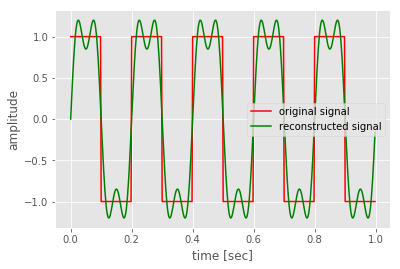

In [8]:
# Cell 7: reconstruct signal using convergence criterion
n = 5                 # number of coefficients (initial: 5)
T_ = 1/freq           # period of signal

# determine coefficients
a0 = 0
a = []
b = []
for i in range(1,n):
    if (i%2 != 0):
        a_ = 4/(np.pi*i)
    else:
        a_ = 0
    a.append(a_)
    b_ = (2*np.pi*i)/T_
    b.append(b_)

# reconstruct signal
g = np.ones_like(t_) * a0
for k, (ak, bk) in enumerate(zip(a, b)):
    g += ak * np.sin(bk*t_)

# plotting
plt.plot(t_, square, 'r', label='original signal')                  
plt.plot(t_, g, 'g', label='reconstructed signal')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
#plt.ylim(-1.1,1.1)
plt.legend()
plt.show()

---

### Fourier transformation

Let us now do the Fourier transformation of the signal created in cell 3 and have a look on the amplitude spectra. In computer science the transformation is performed as fast Fourier transformation (FFT).    

7) Why do we need to taper the signal before we perform the FFT?  
8) How do you interpret the plot of the amplitude spectra?  
9) Which frequency contributes most to the final signal?   

samp = 3000  Need to be the same as in cell 3.
T = 1  Need to be the same as in cell 3.


Text(0, 0.5, 'Amplitude')

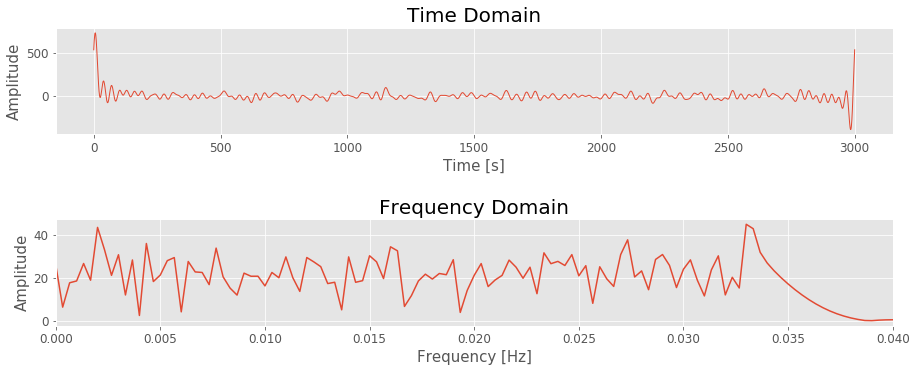

In [11]:
# Cell 8: FFT of signal
# number of sample points need to be the same as in cell 3
print('samp =',samp,' Need to be the same as in cell 3.')
# number of sample points need to be the same as in cell 3
print('T =',T,' Need to be the same as in cell 3.')
# percentage of taper applied to signal (initial: 0.1)
taper_percentage = 0.1
taper = cosine_taper(samp,taper_percentage)

sig_ = sig * taper
Fsig = np.fft.rfft(sig_, n=samp)

# prepare plotting
xf = np.linspace(start=0.0, stop=1.0/(2.0*T),num=int((samp/2)+1))
rcParams["figure.subplot.hspace"] = (0.8)
rcParams["figure.figsize"] = (15, 9)
rcParams["axes.labelsize"] = (15)
rcParams["axes.titlesize"] = (20)
rcParams["font.size"] = (12)
 
#plotting
plt.subplot(311)
plt.title('Time Domain')
plt.plot(t, sig, linewidth=1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(312)
plt.title('Frequency Domain')
plt.plot(xf, 2.0/npts * np.abs(Fsig))
plt.xlim(0, 0.04)                                
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')